## Document Vectors

In [4]:
import pandas as pd
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords
import random

import warnings
warnings.filterwarnings("ignore")

In [5]:
pd.set_option('display.max_colwidth', -1)

In [6]:
movie_lines_file = '../data/cornell-movie-dialogs/movie_lines.txt'

## Load the Movie Dialogs

In [7]:
with open(movie_lines_file) as f:
    movie_lines = [line.strip().split('+++$+++') for line in f.readlines()];

lines_df = pd.DataFrame([{'LineNumber': d[0].strip(), 
                                'Person': d[3].strip(),
                                'Line': d[4].strip(),
                                 'Movie' : d[2].strip()} 
                              for d in movie_lines])
lines_df = lines_df.set_index('LineNumber')

In [8]:
lines_df.head(10)

,Line,Movie,Person
LineNumber,,,
L1045,They do not!,m0,BIANCA
L1044,They do to!,m0,CAMERON
L985,I hope so.,m0,BIANCA
L984,She okay?,m0,CAMERON
L925,Let's go.,m0,BIANCA
L924,Wow,m0,CAMERON
L872,Okay -- you're gonna need to learn how to lie.,m0,BIANCA
L871,No,m0,CAMERON
L870,"I'm kidding. You know how sometimes you just become this ""persona""? And you don't know how to quit?",m0,BIANCA


In [9]:
len(lines_df)

304713

In [10]:
lines_df.nunique()

Line      265786
Movie     617   
Person    5356  
dtype: int64

In [11]:
lines_df_small = lines_df.head(30000)

In [12]:
class DocumentDataset(object):
    
    def __init__(self, data:pd.DataFrame, column):
        document = data[column].apply(self.preprocess)
        self.documents = [ TaggedDocument( text, [index]) 
                          for index, text in document.iteritems() ]
      
    def preprocess(self, document):
        return preprocess_string(remove_stopwords(document))
        
    def __iter__(self):
        for document in self.documents:
            yield documents
            
    def tagged_documents(self, shuffle=False):
        if shuffle:
            random.shuffle(self.documents)
        return self.documents

In [13]:
documents_dataset = DocumentDataset(lines_df_small, 'Line')

## Document Vector Model

In [14]:
docVecModel = Doc2Vec(min_count=1, window=5, vector_size=100, sample=1e-4, negative=5, workers=8)
docVecModel.build_vocab(documents_dataset.tagged_documents())

In [15]:
docVecModel.train(documents_dataset.tagged_documents(shuffle=True),
            total_examples = docVecModel.corpus_count,
           epochs=50)

In [16]:
docVecModel.corpus_count

30000

In [17]:
docVecModel.save('../data/MovieLinesModel.d2v')

In [18]:
docVecModel = Doc2Vec.load('../data/MovieLinesModel.d2v')

In [19]:
docVecModel['L872']

array([ 4.40097461e-03,  2.78604613e-03, -2.24419031e-02,  1.29538802e-02,
        4.61672619e-03, -8.64336174e-03, -2.01568007e-02,  1.92502718e-02,
       -9.13647935e-03,  2.75025982e-02, -8.43802746e-03, -6.39368373e-05,
        6.15436165e-03, -1.13167930e-02, -1.48954485e-02,  8.81604198e-03,
        8.01000185e-03,  2.41478458e-02,  1.65130682e-02, -4.05534822e-03,
       -1.10863615e-02, -1.68663356e-02, -5.59257949e-03,  2.94402475e-03,
        2.49123666e-02,  6.84107747e-03, -8.21963511e-03, -1.97309013e-02,
       -6.91878283e-03,  5.68751572e-03,  1.04955968e-03, -1.69414340e-03,
        2.61942986e-02, -3.17532867e-02,  2.52962834e-03,  1.26088727e-02,
        5.18507510e-03,  1.26709035e-02,  3.52681126e-03, -1.34371202e-02,
       -3.08749615e-03, -2.52749715e-02,  5.94890164e-03,  1.27426011e-03,
       -1.66254919e-02,  1.32340500e-02,  1.50057301e-02,  1.56914908e-02,
       -2.81982939e-03,  8.05057026e-03, -2.42782459e-02,  7.21282372e-03,
       -3.36784148e-03,  

In [20]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def show_image(vector, line):
    fig, ax = plt.subplots(1,1, figsize=(10, 2))
    ax.tick_params(axis='both', 
                   which='both',
                   left=False, 
                   bottom=False, 
                   top=False,
                   labelleft=False, 
                   labelbottom=False)
    ax.grid(False)
    print(line)
    ax.bar(range(len(vector)), vector, 0.5)
   
    
def show_movie_line(line_number):
    line = lines_df_small.ix[line_number].Line
    doc_vector = docVecModel.docvecs[line_number]
    show_image(doc_vector, line)
    

Okay -- you're gonna need to learn how to lie.


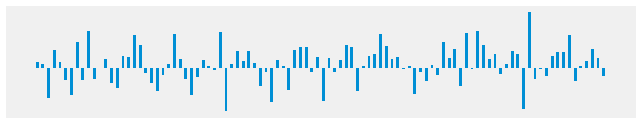

In [21]:
show_movie_line('L872')

In [22]:
docVecModel.docvecs.most_similar('L872')

[('L59615', 0.9660189151763916),
 ('L6502', 0.9659306406974792),
 ('L170856', 0.9658141732215881),
 ('L203270', 0.9655163288116455),
 ('L61979', 0.9651641249656677),
 ('L83914', 0.964946448802948),
 ('L84200', 0.9648617506027222),
 ('L97200', 0.964702308177948),
 ('L83850', 0.9645901918411255),
 ('L122772', 0.9644975066184998)]

In [23]:
docVecModel['L3246']

array([ 0.04467328,  0.0143785 , -0.15610659,  0.10056153,  0.07122061,
       -0.03627344, -0.13998666,  0.12866235, -0.04075407,  0.19679004,
       -0.04774385, -0.02180603, -0.00937082, -0.06378372, -0.09269889,
        0.11317018,  0.11820882,  0.10451771,  0.08215316, -0.05749677,
       -0.09087139, -0.14015166, -0.06572058,  0.0667736 ,  0.134122  ,
        0.00535988, -0.0513141 , -0.15666133, -0.02462175,  0.05262731,
       -0.00960157, -0.00327661,  0.14563069, -0.25182366,  0.02351146,
        0.06236621, -0.02751246,  0.06654667,  0.04796163, -0.06927891,
        0.04259865, -0.13581195,  0.06057135,  0.04003612, -0.07695772,
        0.09608059,  0.03635362,  0.11304905, -0.04020906,  0.08784366,
       -0.13704187,  0.03756823, -0.02769779,  0.04200236,  0.10548777,
        0.03403764, -0.11432595, -0.04218366,  0.0612223 ,  0.0899286 ,
        0.1194454 ,  0.07523538,  0.0761086 ,  0.01876008,  0.02386896,
        0.0327952 , -0.08035155,  0.03655336, -0.08008802, -0.03

In [24]:
def to_vector(sentence):
    cleaned = preprocess_string(sentence)
    docVector = docVecModel.infer_vector(cleaned)
    return docVector

Okay -- you're gonna need to learn how to lie.


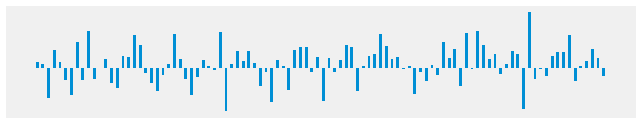

In [25]:
show_movie_line('L872')

you're gonna need to learn not to tell lies


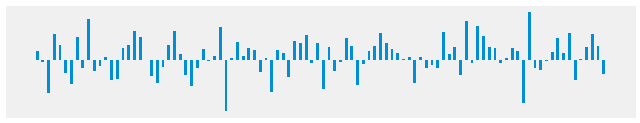

In [26]:
line = "you're gonna need to learn not to tell lies"
show_image(to_vector("you're gonna need to learn how to lie"), line)

In [27]:
def similar_movie_lines(sentence):
    vector = to_vector(sentence)
    similar_vectors = docVecModel.docvecs.most_similar(positive=[vector])
    similar_lines = [ lines_df_small.ix[line[0]].Line for line in similar_vectors]
    return similar_lines

similar_movie_lines("Oh, I don't know. I mean look around. Isn't this a fun place?")

["Take him? Now wait... I didn't take him anywhere. We were just having some fun. We didn't hurt him... just having a laugh, that's all.",
 "Oh, I don't know. I mean look around. Isn't this a fun place?",
 'Not as much fun as the bachelor party the guys are throwing for me.',
 "They will make fun of you for listening to an old woman's stories?",
 "The point I'm trying to make is that this is a blessing.  It's going to be fun doing this show and we should all look at it that way.",
 'No, have fun first. Then laugh. Now, forget about marriage for a while. Go party.',
 "Want to hear something great? Bobbie and Phoebe are throwing me a shower. It's really gonna be fun.",
 "You're making fun of my family. You know there's nothing to steal from my mom and Craig. You know exactly what you're saying.",
 'Those boys, those sad, raging boys... They came to me as the needy do. And like many of the needy, they were rude. Like all the needy, they took. And like all the needy, they needed.  Father. 

In [28]:
lines_df_small.ix['L59293'].Line

'Okay, ten thousand plus a G.E. toaster oven, a Litton microwave, a Cuisinart...'

In [29]:
docVecModel.docvecs.most_similar('a')

TypeError: '<' not supported between instances of 'str' and 'int'